TODO:
- $\psi_1$ and $\sigma_{w,1}^2$
- cheating with Kalman filter initialization
- inefficient

In [1]:
using Distributions
using Gadfly
using StatsBase     # for autocorrelation!
using TimerOutputs

In [2]:
include("../src_old/ssm.jl")
include("../src_old/dfm.jl");

In [3]:
n = 20

μ = zeros(n)
λ = randn(n)
ϕ = 0.95
σ2v = 1.
ψ = 0.90*ones(n)
σ2w = [0.5*ones(n/2)..., 1.*ones(n/2)...]

dfm = MixedFreqDFM(μ, λ, ϕ, σ2v, ψ, σ2w)
ssm = get_state_space_representation(dfm)
xf1, Σxf1 = get_Kalman_filter_initialization(dfm)

T1 = 300
ΔT = 24     # 2 years
T = T1 + ΔT
x, y_unobs = simulate(ssm, xf1, Σxf1, T)

y = fill(NaN, T, n)
y[3:3:T1,1] = y_unobs[3:3:T1,1]
y[1:T1,2:n] = y_unobs[1:T1,2:n]

#y = y_unobs

y

324×20 Array{Float64,2}:
 NaN          1.80383     -2.51022      -3.05107  …   -1.2745        5.62745 
 NaN          3.2176      -2.71519      -4.94915      -0.470395      8.78616 
  -6.3154     2.43002     -1.48548      -4.83152       0.56529       8.17153 
 NaN          2.42077     -0.511792     -3.68059       0.362263      7.08143 
 NaN          2.14611     -0.00640843   -3.26902       0.0523886     5.11287 
  -5.69809    0.342048     0.883983     -3.02274  …    0.739118      3.28716 
 NaN          0.0887338   -1.04848      -3.75637       0.500493      3.44928 
 NaN         -1.75619     -0.46027      -2.28323       0.682739      1.76966 
  -1.06807   -1.21744     -1.62435      -3.04635       0.122439      0.965593
 NaN          0.479749    -2.07055      -4.28458       1.50848       2.27809 
 NaN          1.50301     -3.10205      -6.32163  …   -0.00932856    5.12801 
  -5.58502    0.904877    -2.35761      -4.58812      -0.920329      3.55373 
 NaN          0.82495     -1.29474     

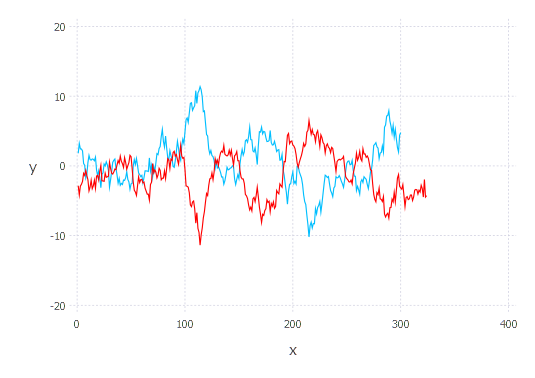

In [4]:
plot(
    layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
    [layer(x=1:T, y=y[:,i], Geom.line) for i=2:2]... 
    # does not work for quarterly series with NaNs
    )

In [5]:
function autocov_q(ψ, Δt)
    return 19*ψ^(abs(Δt)) + 16*ψ^(abs(Δt-1)) + 16*ψ^(abs(Δt+1)) + 10*ψ^(abs(Δt-2))+10*ψ^(abs(Δt+2)) +
                             4*ψ^(abs(Δt-3)) +  4*ψ^(abs(Δt+3)) +    ψ^(abs(Δt-4))+   ψ^(abs(Δt+4))
end

function autocov_m(ψ, Δt)
    return ψ^abs(Δt)
end

function get_covariance_matrix_q(ψ, σ2w, T)
    Φ = σ2w/(1-ψ^2)*[autocov_q(ψ, i-j) for i=1:T, j=1:T]
    return Φ
end

function get_covariance_matrix_m(ψ, σ2w, T)
    Φ = σ2w/(1-ψ^2)*[autocov_m(ψ, i-j) for i=1:T, j=1:T]
    return Φ
end

get_covariance_matrix_m (generic function with 1 method)

In [1]:
const to = TimerOutput()

T, _ = size(y)
n, k = size(ssm.B)

S = 2000

# parameters of priors
aσ2v_prior = 1.
bσ2v_prior = 1.
aσ2w_prior = 1.
bσ2w_prior = 1.
μλ_prior   = zeros(n)
σ2λ_prior  = 100.*ones(n)

# TODO: this is cheating
# initialization
μ_mcmc   = copy(dfm.μ)
λ_mcmc   = [dfm.λ[1], 1.*randn(n-1)...]
ϕ_mcmc   = 0.
ψ_mcmc   = zeros(n)
σ2v_mcmc = 1.
σ2w_mcmc = ones(n)

# for storage
x_all   = zeros(S, T, k)
μ_all   = zeros(S, n)
λ_all   = zeros(S, n)
ϕ_all   = zeros(S, 1)
ψ_all   = zeros(S, n)
σ2v_all = zeros(S, 1)
σ2w_all = zeros(S, n)
ypred_all = zeros(S, ΔT+1, n)

# TODO: cheating to circumvent problem
xf1_mcmc, Σxf1_mcmc  = get_Kalman_filter_initialization(dfm)

for s=1:S
    
    @timeit to "simulation smoother" begin
        
        dfm_mcmc = MixedFreqDFM(μ_mcmc, λ_mcmc, ϕ_mcmc, σ2v_mcmc, ψ_mcmc, σ2w_mcmc)
        ssm_mcmc = get_state_space_representation(dfm_mcmc)
        # TODO: cheating to circumvent problem
        # xf1_mcmc, Σxf1_mcmc = get_Kalman_filter_initialization(dfm_mcmc)
        
        @timeit to "fast state smoothing" begin
        xs = fast_state_smoothing(y, ssm_mcmc, xf1_mcmc, Σxf1_mcmc)
        end
        x1, y1 = simulate(ssm_mcmc, xf1_mcmc, Σxf1_mcmc, T)
        y1[isnan.(y)] = NaN
        @timeit to "fast state smoothing" begin
        xs1  = fast_state_smoothing(y1, ssm_mcmc, xf1_mcmc, Σxf1_mcmc)
        end
        x_mcmc = x1 - xs1 + xs
        
        flags_mcmc = x_mcmc[:,1:5]
        # TODO: forget part that relates to u_mcmc
        
    end
    
    @timeit to "sample y_pred" begin
        
        ypred_mcmc = ones(ΔT+1,1)*μ_mcmc'+x_mcmc[T1:T,:]*ssm_mcmc.B'
        
    end
    
    @timeit to "sample μ1 and λ1" begin
        
        i = 1 # (quarterly data)
        
            #=
        
            @timeit to "cov matrix quarterly" begin
            Φ = σ2w[1]/(1-ψ[1]^2)*[autocov_q(ψ[1], i-j) for i=1:T, j=1:T] #get_covariance_matrix_q(ψ[i], σ2w[i], T)
            end

            Si = diagm(.~isnan.(y[:,1]))

            favg = 1/3*x_mcmc[:,1] + 2/3*x_mcmc[:,2] + x_mcmc[:,3] + 2/3*x_mcmc[:,4] + 1/3*x_mcmc[:,5]
            favg_S = Vector(sparse(Si)*favg)
            b_S = Vector(sparse(Si)*(y[:,1]-μ_mcmc[i]))
            Jλ = favg_S'*(Φ\favg_S) + 1/σ2λ_prior[i]
            hλ = favg_S'*(Φ\b_S) + μλ_prior[i]/σ2λ_prior[i]
            λ_mcmc[i] = rand(Normal(hλ/Jλ,sqrt(1/Jλ)))
        
            =#
        
            @timeit to "cov matrix quarterly" begin
            Φ = σ2w[1]/(1-ψ[1]^2)*[autocov_q(ψ[1], i-j) for i=3:3:T1, j=3:3:T1] #get_covariance_matrix_q(ψ[i], σ2w[i], T)
            end

            Si = diagm(.~isnan.(y[3:3:T1,1]))

            favg = 1/3*x_mcmc[3:3:T1,1] + 2/3*x_mcmc[3:3:T1,2] + x_mcmc[3:3:T1,3] + 2/3*x_mcmc[3:3:T1,4] + 1/3*x_mcmc[3:3:T1,5]
            favg_S = Vector(sparse(Si)*favg)
            b_S = Vector(sparse(Si)*(y[3:3:T1,1]-μ_mcmc[i]))
            Jλ = favg_S'*(Φ\favg_S) + 1/σ2λ_prior[i]
            hλ = favg_S'*(Φ\b_S) + μλ_prior[i]/σ2λ_prior[i]
            λ_mcmc[i] = rand(Normal(hλ/Jλ,sqrt(1/Jλ)))
        
    end
    
    @timeit to "sample μi and λi for i not 1" begin
        
        f = flags_mcmc[:,1]
        
        for i = 2:n # (monthly data)
            
            #=
            
            @timeit to "cov matrix monthly" begin
                Φ = get_covariance_matrix_m(ψ[i], σ2w[i], T)
            end
            
            Si = diagm(.~isnan.(y[:,i]))
            f_S = Vector(sparse(Si)*f)
            b_S = Vector(sparse(Si)*(y[:,i]-μ_mcmc[i]))
            Jλ = f_S'*(Φ\f_S) + 1/σ2λ_prior[i]
            hλ = f_S'*(Φ\b_S) + μλ_prior[i]/σ2λ_prior[i]
            λ_mcmc[i] = rand(Normal(hλ/Jλ,sqrt(1/Jλ)))
            
            =#
            
            y_transf = zeros(T1)
            f_transf = zeros(T1)
            
            y_transf[1] = 1/(1-ψ_mcmc[i]^2)*(y[1,i]-μ_mcmc[i])
            f_transf[1] = 1/(1-ψ_mcmc[i]^2)*f[1]
            
            y_transf[2:T1] = y[2:T1,i] - ψ_mcmc[i]*y[1:T1-1,i] - (1-ψ_mcmc[i])*μ_mcmc[i]
            f_transf[2:T1] = f[2:T1]   - ψ_mcmc[i]*f[1:T1-1]
            
            Jλ = σ2w_mcmc[i]^(-1)*f_transf'*f_transf + σ2λ_prior[i]^(-1)
            hλ = σ2w_mcmc[i]^(-1)*f_transf'*y_transf + σ2λ_prior[i]^(-1)*μλ_prior[i]
            λ_mcmc[i] = rand(Normal(hλ/Jλ,sqrt(1/Jλ)))         
            
            
        end
        
    end
    
    @timeit to "sample ϕ and σ2v" begin
    
        # TODO: initialization of simulation smoother matters
        # TODO: why not use data back to -3
        
        f_mcmc = flags_mcmc[:,1]
        
        # vague prior
        Jϕ = σ2v_mcmc^(-2)*f_mcmc[1:T-1]'*f_mcmc[1:T-1]
        hϕ = σ2v_mcmc^(-2)*f_mcmc[1:T-1]'*f_mcmc[2:T]
        ϕ_mcmc = rand(TruncatedNormal(hϕ/Jϕ,sqrt(1/Jϕ), -1, 1))
        
        # commented out for identification!
        
        #=
        Δf_mcmc = f_mcmc[2:T] - ϕ_mcmc*f_mcmc[1:T-1]
        aσ2v = (T-1)/2 + aσ2v_prior 
        bσ2v = Δf_mcmc'*Δf_mcmc/2 + bσ2v_prior
        σ2v_mcmc = rand(InverseGamma(aσ2v, bσ2v))
        =#
        
    end
    
    @timeit to "sample ψ and σ2w" begin
        
        # TODO: initialization of simulation smoother matters
        # TODO: why not use data back to -3
        
        # TODO: do not (!) use  data from x_mcmc
        
        ψ_mcmc   = copy(dfm.ψ)
        σ2w_mcmc = copy(dfm.σ2w)
        
        # TODO: this part does not work properly
        
        #=
        i = 1
        
            Si = diagm(.~isnan.(y[:,i]))
            y_S = Vector(sparse(Si)*y[:,i])
            favg = 1/3*x_mcmc[:,1] + 2/3*x_mcmc[:,2] + x_mcmc[:,3] + 2/3*x_mcmc[:,4] + 1/3*x_mcmc[:,5]
            favg_S = Vector(sparse(Si)*favg)
            
            u_mcmc = y_S - μ_mcmc[i] - λ_mcmc[i]*favg_S
            
            Jψ = σ2w_mcmc[i]^(-2)*u_mcmc[1:T-1]'*u_mcmc[1:T-1]
            hψ = σ2w_mcmc[i]^(-2)*u_mcmc[1:T-1]'*u_mcmc[2:T]
            ψ_mcmc[i] = rand(TruncatedNormal(hψ/Jψ,sqrt(1/Jψ), -1, 1))

            Δu_mcmc = u_mcmc[2:T] - ψ_mcmc[i]*u_mcmc[1:T-1]
            aσ2w = (T-1)/2 + aσ2w_prior 
            bσ2w = Δu_mcmc'*Δu_mcmc/2 + bσ2w_prior
            σ2w_mcmc[i] = rand(InverseGamma(aσ2w, bσ2w))
        
        =#
        
        for i = 2:n
            
            Si = diagm(.~isnan.(y[:,i]))
            y_S = Vector(sparse(Si)*y[:,i])
            f_S = Vector(sparse(Si)*f)
            
            u_mcmc = y_S - μ_mcmc[i] - λ_mcmc[i]*f_S
            
            Jψ = σ2w_mcmc[i]^(-2)*u_mcmc[1:T-1]'*u_mcmc[1:T-1]
            hψ = σ2w_mcmc[i]^(-2)*u_mcmc[1:T-1]'*u_mcmc[2:T]
            ψ_mcmc[i] = rand(TruncatedNormal(hψ/Jψ,sqrt(1/Jψ), -1, 1))

            Δu_mcmc = u_mcmc[2:T] - ψ_mcmc[i]*u_mcmc[1:T-1]
            aσ2w = (T-1)/2 + aσ2w_prior 
            bσ2w = Δu_mcmc'*Δu_mcmc/2 + bσ2w_prior
            σ2w_mcmc[i] = rand(InverseGamma(aσ2w, bσ2w))
            
        end
        
    end 

    
    @timeit to "save" begin
        
        x_all[s,:,:] = x_mcmc
        μ_all[s,:]   = μ_mcmc
        λ_all[s,:]   = λ_mcmc
        ϕ_all[s,:]   = ϕ_mcmc
        ψ_all[s,:]   = ψ_mcmc
        σ2v_all[s,:] = σ2v_mcmc
        σ2w_all[s,:] = σ2w_mcmc
        
        ypred_all[s,:,:] = ypred_mcmc
        
    end
    
end

LoadError: [91mUndefVarError: TimerOutput not defined[39m

In [7]:
show(to)

 ──────────────────────────────────────────────────────────────────────────────
                                       Time                   Allocations      
                               ──────────────────────   ───────────────────────
       Tot / % measured:             235s / 99.1%            155GiB / 100%     

 Section               ncalls     time   %tot     avg     alloc   %tot      avg
 ──────────────────────────────────────────────────────────────────────────────
 simulation smoother    2.00k     185s  79.5%  92.5ms    147GiB  94.7%  75.3MiB
   fast state smoot...  4.00k     183s  78.5%  45.7ms    145GiB  93.5%  37.1MiB
 sample μ1 and λ1       2.00k    26.4s  11.3%  13.2ms   3.35GiB  2.16%  1.72MiB
   cov matrix quart...  2.00k    20.7s  8.88%  10.3ms   2.99GiB  1.92%  1.53MiB
 sample ψ and σ2w       2.00k    20.4s  8.76%  10.2ms   3.33GiB  2.15%  1.71MiB
 sample μi and λi f...  2.00k    524ms  0.23%   262μs   1.40GiB  0.90%   735KiB
 save                   2.00k    315ms 

# Output of the Gibbs sampler

In [8]:
c = 500;

### Time evolution of factors

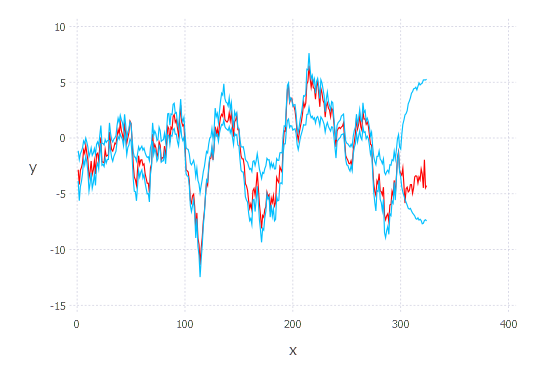

In [9]:
plot(
    [layer(x=1:T, y=[quantile(x_all[c+1:end,t,1],q) for t=1:T], Geom.line) for q=[0.025, 0.975]]...,
    layer(x=1:T, y=x[:,1], Geom.line, Theme(default_color="red")),
)

### Time evolution of idiosyncratic components

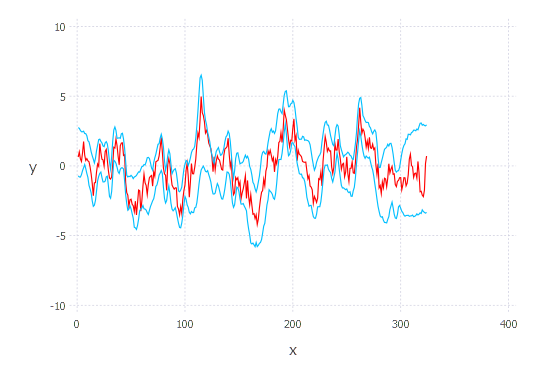

In [10]:
plot(
    [layer(x=1:T, y=[quantile(x_all[c+1:end,t,6],q) for t=1:T], Geom.line) for q=[0.025, 0.975]]...,
    layer(x=1:T, y=x[:,6], Geom.line, Theme(default_color="red")),
)

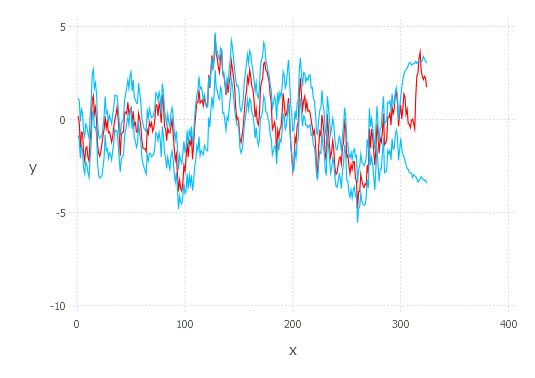

In [11]:
plot(
    [layer(x=1:T, y=[quantile(x_all[c+1:end,t,13],q) for t=1:T], Geom.line) for q=[0.025, 0.975]]...,
    layer(x=1:T, y=x[:,13], Geom.line, Theme(default_color="red")),
)

### Forecasts

In [12]:
ypred_perfect = zeros(S-c, ΔT+1, n)
for s=1:S-c
    _, ypred_perfect[s,:,:] = simulate(ssm, x[T1,:], ΔT+1)
end

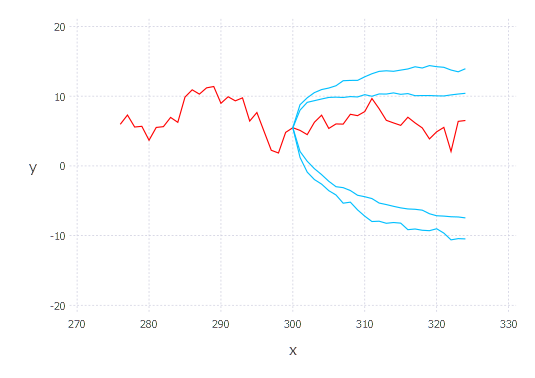

In [13]:
i = 6
plot(
    [layer(x=T1:T, y=[quantile(ypred_all[  c+1:end,t+1,i],q) for t=0:ΔT], Geom.line) for q=[0.025, 0.975]]...,
    [layer(x=T1:T, y=[quantile(ypred_perfect[1:end,t+1,i],q) for t=0:ΔT], Geom.line) for q=[0.025, 0.975]]...,
    layer(x=(T1-ΔT):T, y=y_unobs[(T1-ΔT):T,i], Geom.line, Theme(default_color="red")),
)

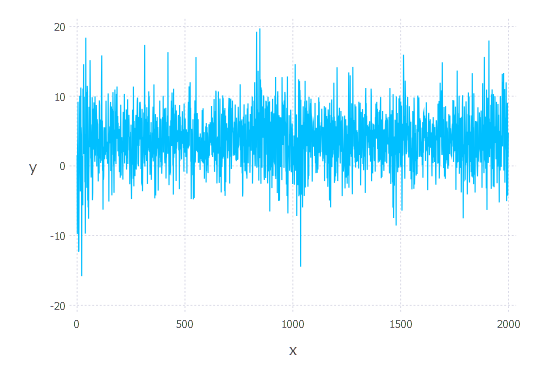

In [27]:
plot(x=0:S-1, y=ypred_all[:,6,i], Geom.line)

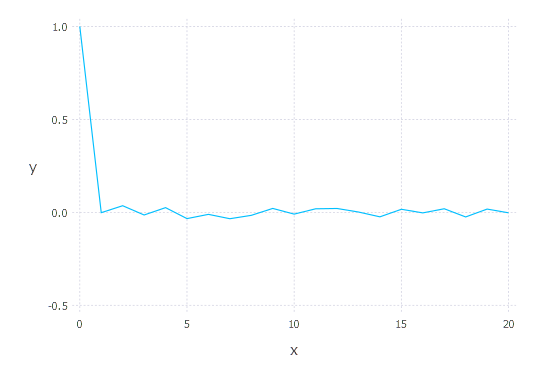

In [28]:
plot(x=0:20, y=autocor(ypred_all[:,2,i], 0:20), Geom.line)

### Posterior distribution of $\mu$ and $\lambda$

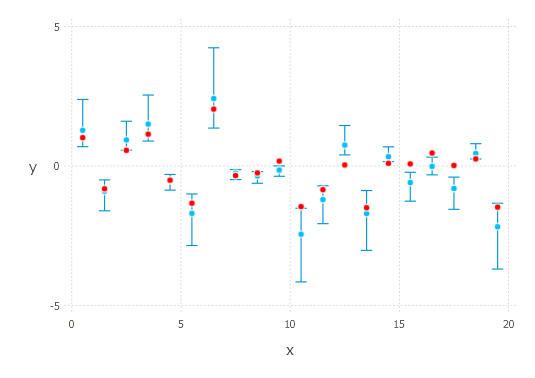

In [29]:
plot(
    layer(
        x=0.5:n-0.5,
        y=dfm.λ,
        Geom.point, Theme(default_color="red")
    ),
    layer(
        x=0.5:n-0.5, 
        y=[median(λ_all[c+1:end,i]) for i=1:n], 
        ymin=[quantile(λ_all[c+1:end,i], 0.025) for i=1:n], 
        ymax=[quantile(λ_all[c+1:end,i], 0.975) for i=1:n],
        Geom.point, Geom.errorbar
    )
)

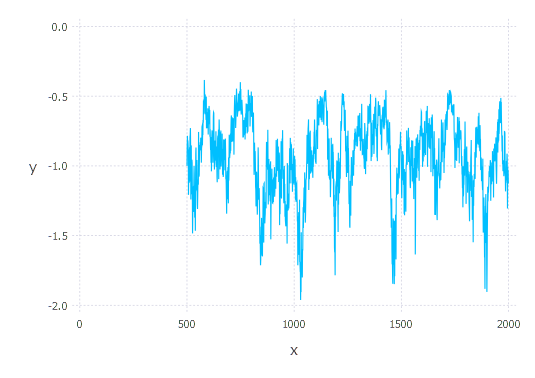

In [31]:
plot(x=c:S-1, y=λ_all[c+1:end,2], Geom.line)

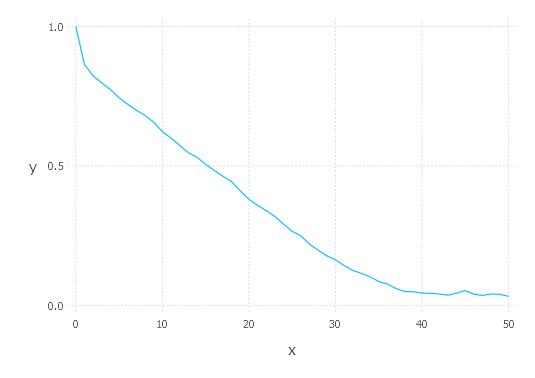

In [33]:
plot(x=0:50, y=autocor(λ_all[c+1:end,2], 0:50), Geom.line)

### Posterior distribution of $\phi$ and $\sigma_v^2$

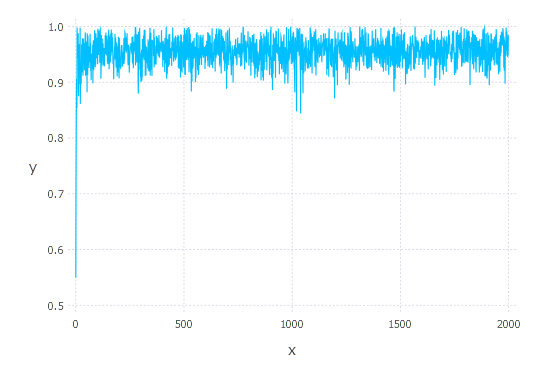

In [34]:
plot(x=0:S-1, y=ϕ_all, Geom.line)

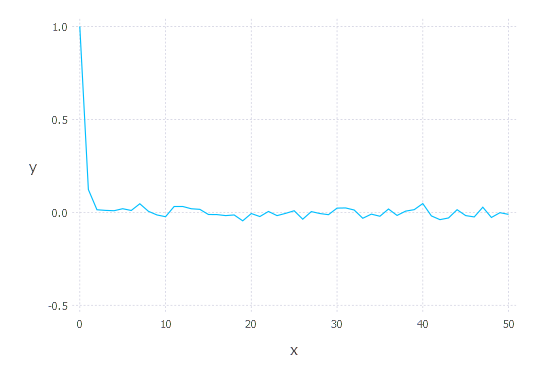

In [35]:
plot(x=0:50, y=autocor(ϕ_all[c+1:end,end], 0:50), Geom.line)

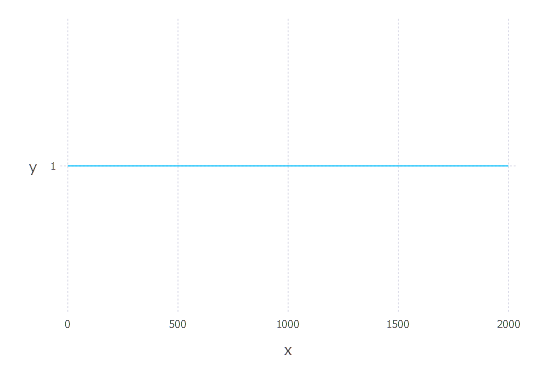

In [36]:
plot(x=0:S-1, y=σ2v_all, Geom.line)

### Posterior distribution of $\psi$ and $\sigma_w^2$

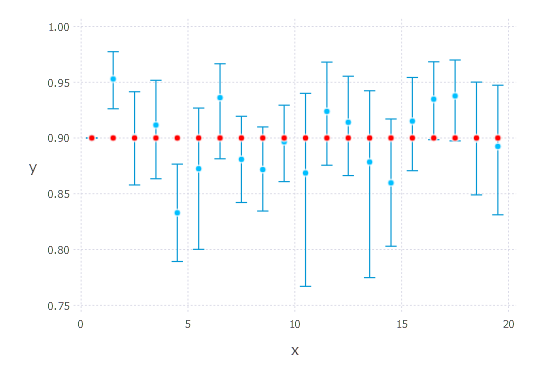

In [37]:
plot(
    layer(
        x=0.5:n-0.5,
        y=dfm.ψ,
        Geom.point, Theme(default_color="red")
    ),
    layer(
        x=0.5:n-0.5, 
        y=   [  median(ψ_all[c+1:end,i])        for i=1:n], 
        ymin=[quantile(ψ_all[c+1:end,i], 0.025) for i=1:n], 
        ymax=[quantile(ψ_all[c+1:end,i], 0.975) for i=1:n],
        Geom.point, Geom.errorbar
    )
)

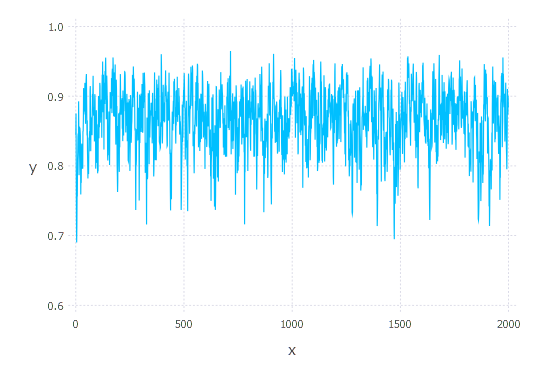

In [46]:
plot(x=0:S-1, y=ψ_all[:,11], Geom.line)

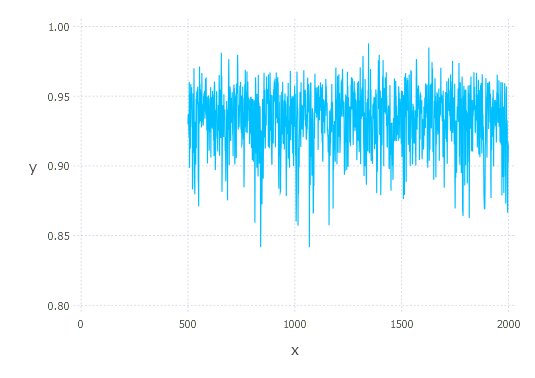

In [47]:
plot(x=0:50, y=autocor(σ2w_all[c+1:end,7], 0:50), Geom.line)

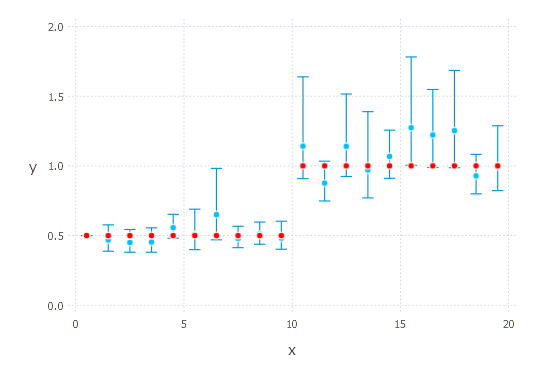

In [39]:
plot(
    layer(
        x=0.5:n-0.5,
        y=dfm.σ2w,
        Geom.point, Theme(default_color="red")
    ),
    layer(
        x=0.5:n-0.5, 
        y=   [median(  σ2w_all[c+1:end,i])        for i=1:n], 
        ymin=[quantile(σ2w_all[c+1:end,i], 0.025) for i=1:n], 
        ymax=[quantile(σ2w_all[c+1:end,i], 0.975) for i=1:n],
        Geom.point, Geom.errorbar
    )
)

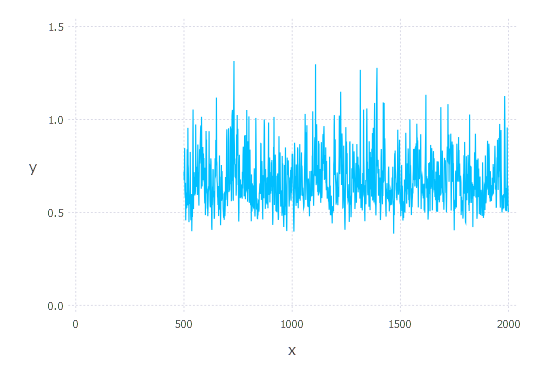

In [44]:
plot(x=c:S-1, y=σ2w_all[c+1:end,7], Geom.line)

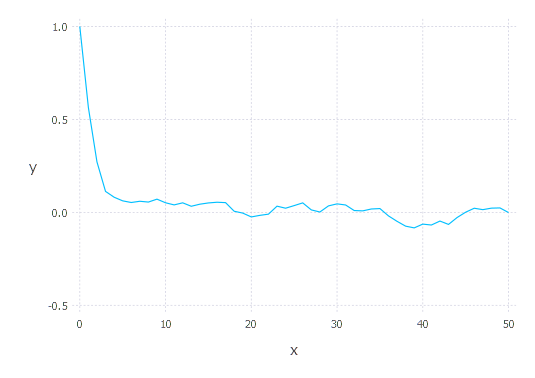

In [45]:
plot(x=0:50, y=autocor(σ2w_all[c+1:end,7], 0:50), Geom.line)